In [29]:
import os
import csv
import lightkurve as lk
from lightkurve import search_targetpixelfile
#import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq
from tqdm import tqdm
import astropy.units as u
import pylab as plt
tpf = search_targetpixelfile('211963497', mission='K2',cadence='short').download()

Could not resolve EPIC to a sky position.
/anaconda3/lib/python3.6/site-packages/lightkurve/search.py:173: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


In [2]:
tpf

KeplerTargetPixelFile Object (ID: 211963497)

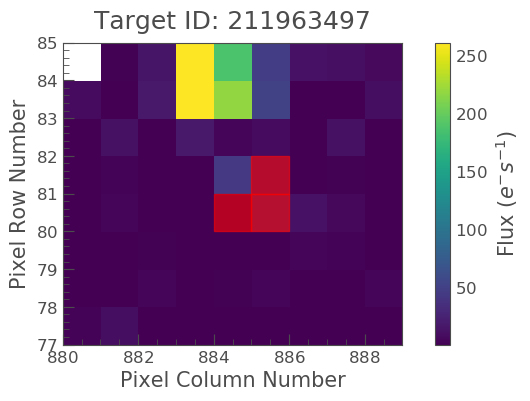

In [3]:
%matplotlib inline
tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='red')

[2306.60131985 2306.60200101 2306.60268206 ... 2381.44097298 2381.44165402
 2381.44233516]
[60.613934 72.93335  68.03374  ... 77.96692  88.967926 97.528244]


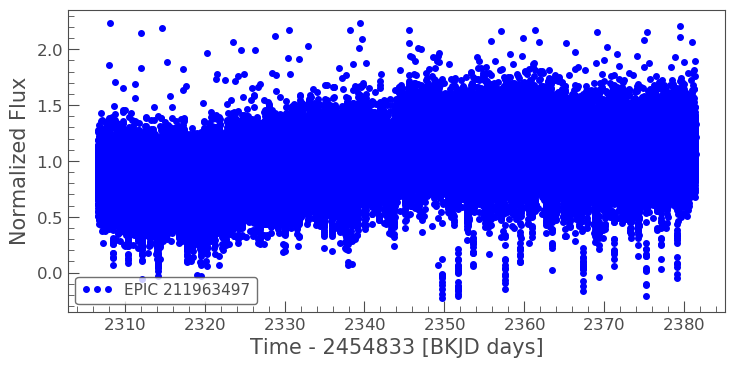

In [4]:
import matplotlib.pyplot as plt

user_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers()
user_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')
#plt.ylim(0.9,1.1)
print(user_lc.time)
print(user_lc.flux)

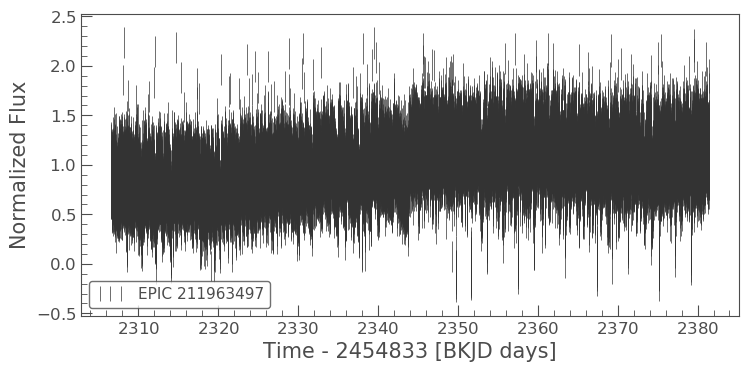

In [5]:
user_lc.errorbar();

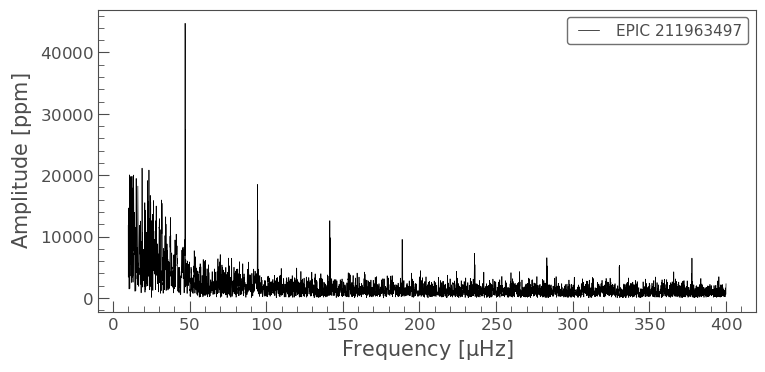

In [6]:
p = user_lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.24563479 d>

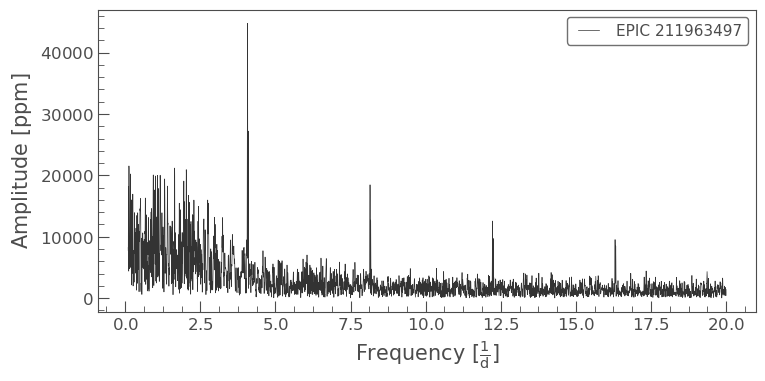

In [7]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


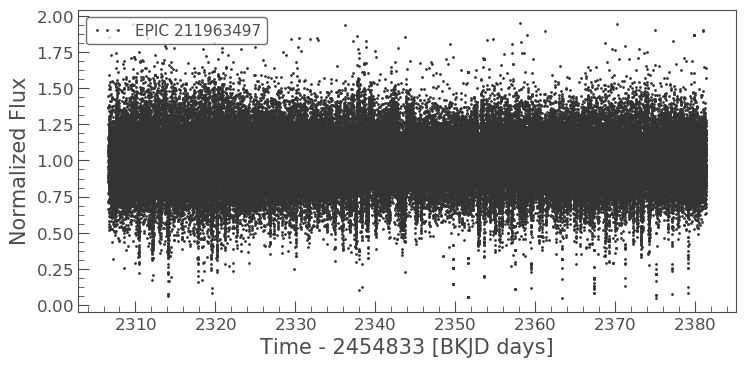

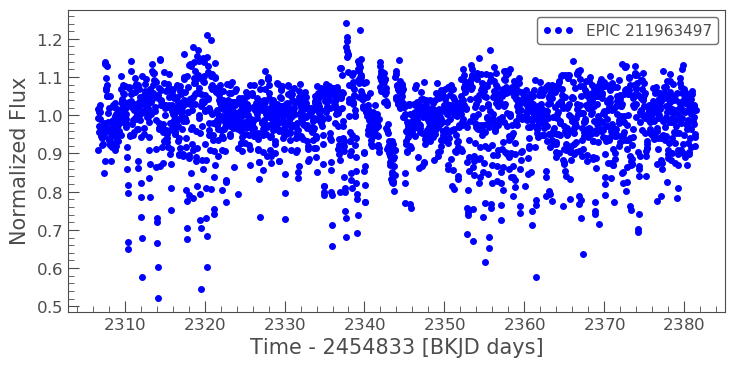

In [8]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()
clc.plot(marker='o',linestyle='none')
bin_corrected_lc = clc.bin(50,method='median')
bin_corrected_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.24558296 d>

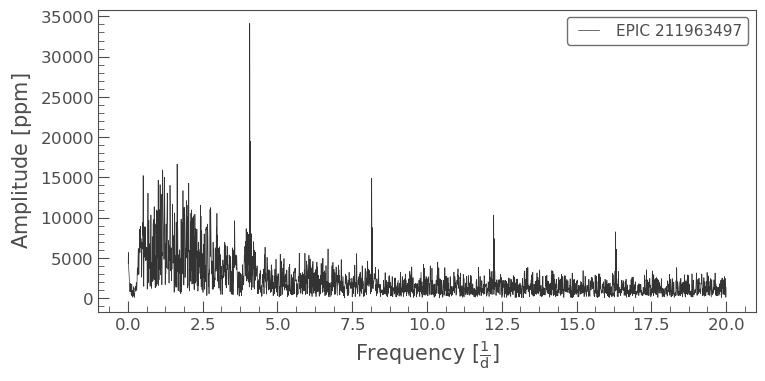

In [9]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

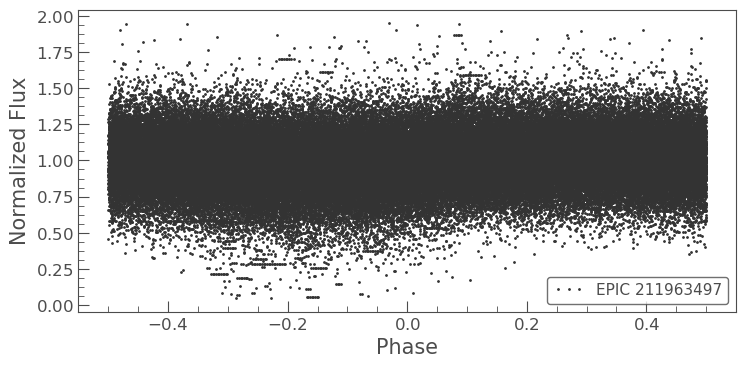

In [10]:
folded_lightcurve = clc.fold(periodogram.period_at_max_power.value)
folded_lightcurve.plot(marker='o',linestyle='none')

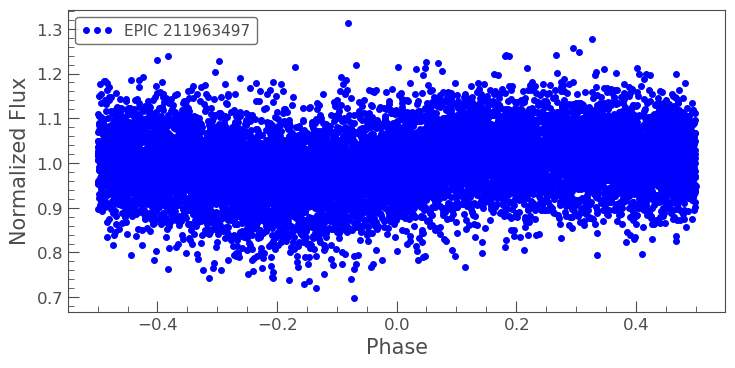

In [11]:
bin_folded_lc = folded_lightcurve.bin(10,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

In [12]:
corrector=lk.SFFCorrector(lc)
new_lc = corrector.correct(lc.centroid_col,lc.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.24558296 d>

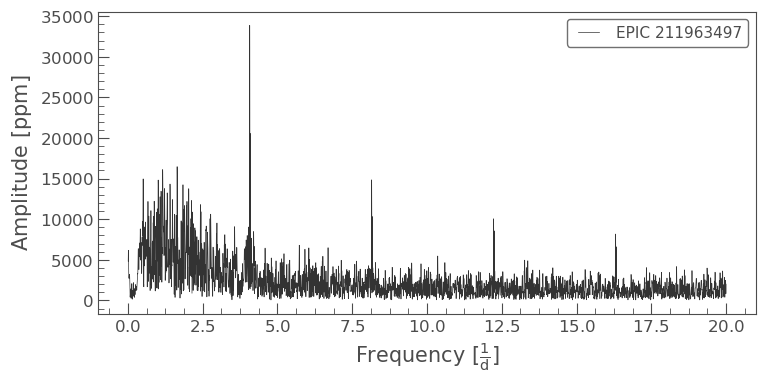

In [13]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

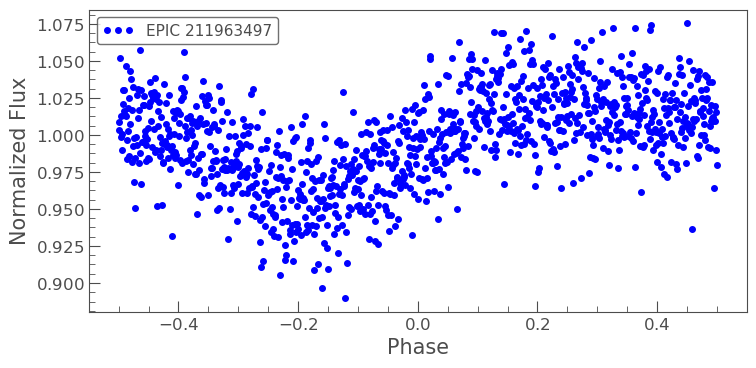

In [14]:
folded_lightcurve = new_lc.fold(periodogram.period_at_max_power.value)
bin_folded_lc = folded_lightcurve.bin(100,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.030490146493854998


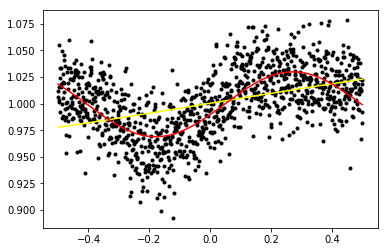

In [15]:
N = len(bin_folded_lc.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc.flux)
guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
print(est_amp)

In [16]:
### THIS IS THE SEPARATION PART OF THE CODE ###


first_time=[]
second_time=[]
third_time=[]
fourth_time=[]
fifth_time=[]
sixth_time=[]
seventh_time=[]
eighth_time=[]
ninth_time=[]
tenth_time=[]
first_flux=[]
second_flux=[]
third_flux=[]
fourth_flux=[]
fifth_flux=[]
sixth_flux=[]
seventh_flux=[]
eighth_flux=[]
ninth_flux=[]
tenth_flux=[]

row=0
first_day=user_lc.time[0]
num_data=user_lc.time.size
last_day=user_lc.time[num_data-1]
print(first_day)
print(last_day)
num_days=last_day-first_day
print(num_days)
sep_length=num_days/10
print(sep_length)


first_day=clc.time[0]
num_data=clc.time.size
last_day=clc.time[num_data-1]
print(first_day)
print(last_day)
num_days=last_day-first_day
print(num_days)
sep_length=num_days/10
print(sep_length)

len(clc.time)

print( first_day+sep_length)

2306.601319851703
2381.4423351627847
74.84101531108172
7.484101531108172
2306.601319851703
2381.4423351627847
74.84101531108172
7.484101531108172
2314.085421382811


In [17]:
for i in clc.time:
    if (i<(first_day+sep_length)):
        first_time.append(i)
        first_flux.append(clc.flux[row])
    if (i>(first_day+sep_length)) and (i<(first_day+2*sep_length)):
        second_time.append(i)
        second_flux.append(clc.flux[row])
    if (i>(first_day+2*sep_length)) and (i<(first_day+3*sep_length)):
        third_time.append(i)
        third_flux.append(clc.flux[row])
    if (i>(first_day+3*sep_length)) and (i<(first_day+4*sep_length)):
        fourth_time.append(i)
        fourth_flux.append(clc.flux[row])
    if (i>(first_day+4*sep_length)) and (i<(first_day+5*sep_length)):
        fifth_time.append(i)
        fifth_flux.append(clc.flux[row])
    if (i>(first_day+5*sep_length)) and (i<(first_day+6*sep_length)):
        sixth_time.append(i)
        sixth_flux.append(clc.flux[row])
    if (i>(first_day+6*sep_length)) and (i<(first_day+7*sep_length)):
        seventh_time.append(i)
        seventh_flux.append(clc.flux[row])
    if (i>(first_day+7*sep_length)) and (i<(first_day+8*sep_length)):
        eighth_time.append(i)
        eighth_flux.append(clc.flux[row])
    if (i>(first_day+8*sep_length)) and (i<(first_day+9*sep_length)):
        ninth_time.append(i)
        ninth_flux.append(clc.flux[row])
    if (i>(first_day+9*sep_length)) and (i<(first_day+10*sep_length)):
        tenth_time.append(i)
        tenth_flux.append(clc.flux[row])
    row=row+1

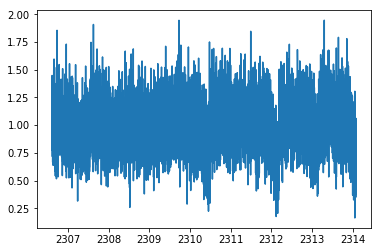

10989


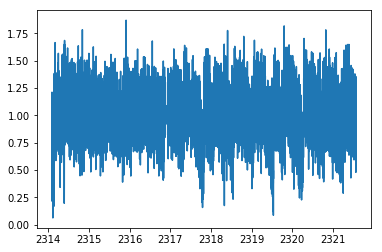

10989


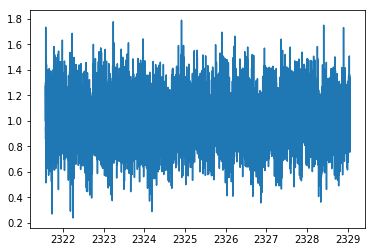

10989


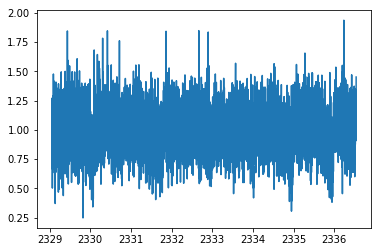

10989


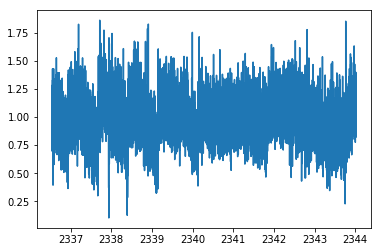

10989


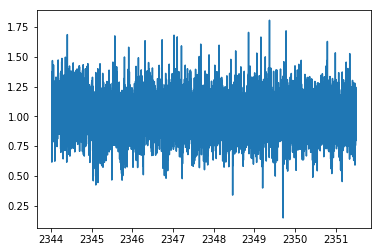

10989


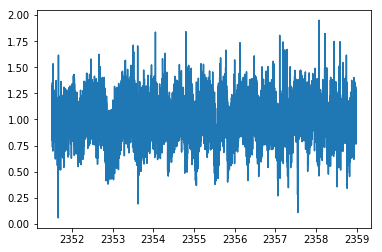

10989


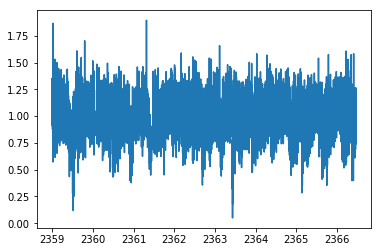

10989


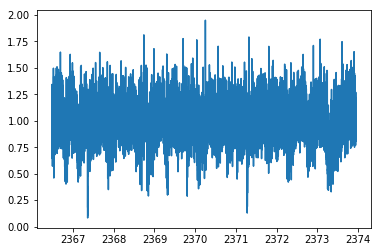

10989


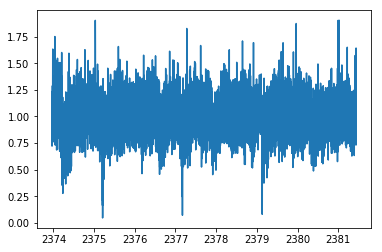

10988


In [18]:
plt.plot(first_time,first_flux)
plt.show()
print(len(first_time))

plt.plot(second_time,second_flux)
plt.show()
print(len(second_time))

plt.plot(third_time,third_flux)
plt.show()
print(len(third_time))

plt.plot(fourth_time,fourth_flux)
plt.show()
print(len(fourth_time))

plt.plot(fifth_time,fifth_flux)
plt.show()
print(len(fifth_time))

plt.plot(sixth_time,sixth_flux)
plt.show()
print(len(sixth_time))

plt.plot(seventh_time,seventh_flux)
plt.show()
print(len(seventh_time))

plt.plot(eighth_time,eighth_flux)
plt.show()
print(len(eighth_time))

plt.plot(ninth_time,ninth_flux)
plt.show()
print(len(ninth_time))

plt.plot(tenth_time,tenth_flux)
plt.show()
print(len(tenth_time))



In [19]:

list_of_time_lengths=[len(first_time),len(second_time),len(third_time),len(fourth_time),len(fifth_time),len(sixth_time),len(seventh_time),len(eighth_time),len(ninth_time),len(tenth_time)]
print(list_of_time_lengths)

[10989, 10989, 10989, 10989, 10989, 10989, 10989, 10989, 10989, 10988]


1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10


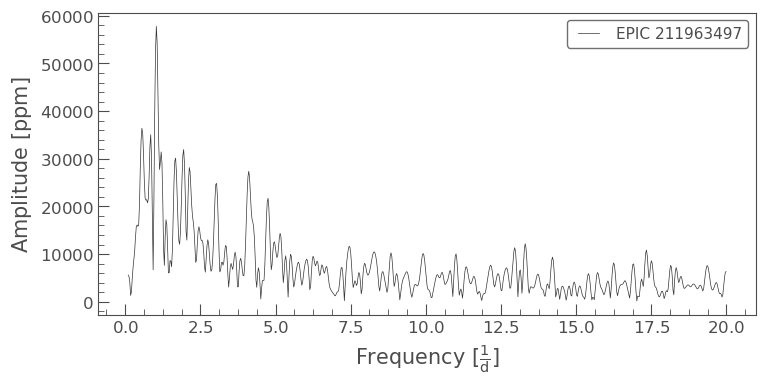

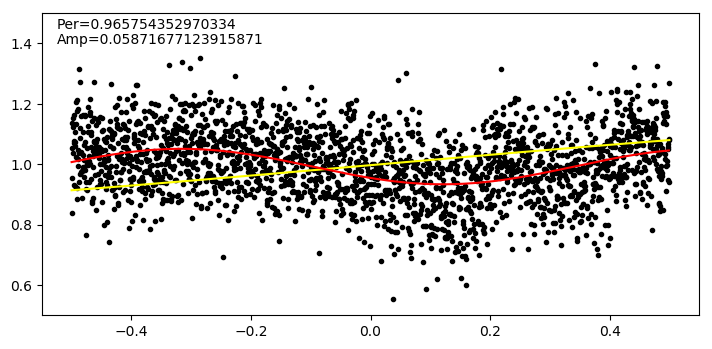

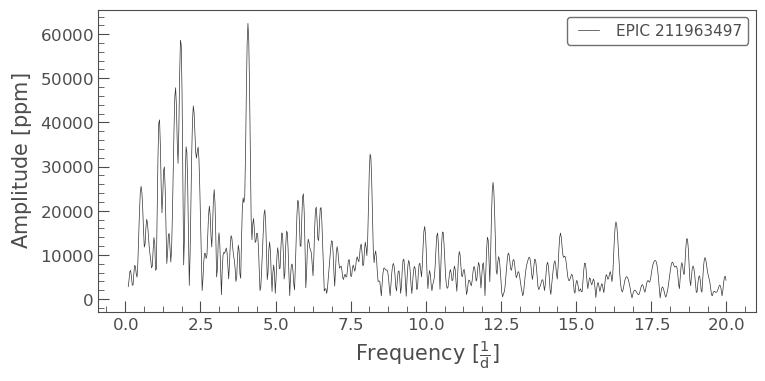

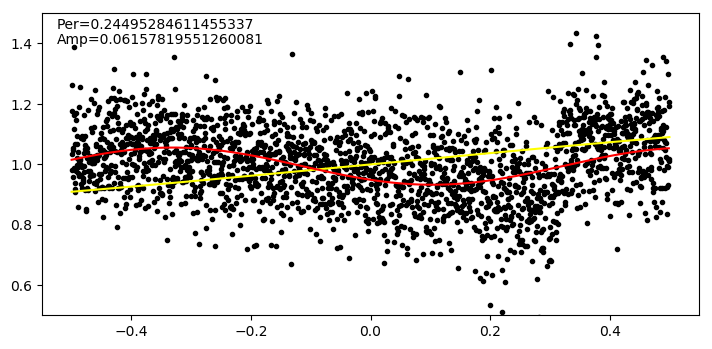

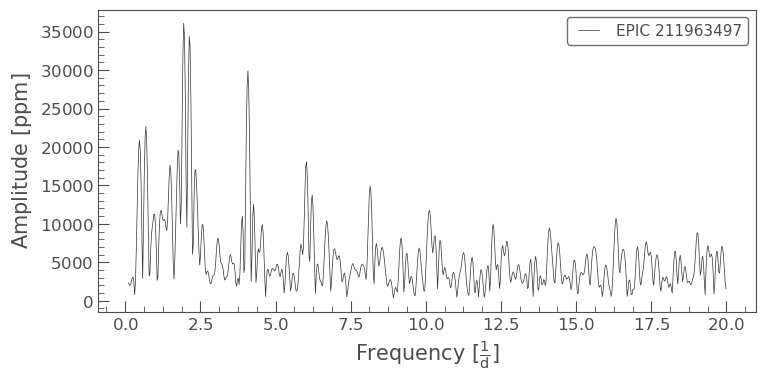

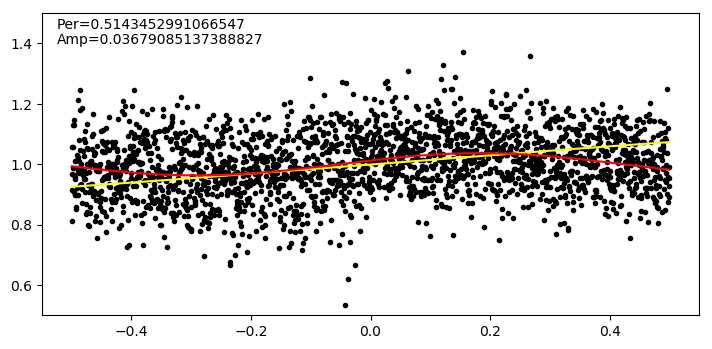

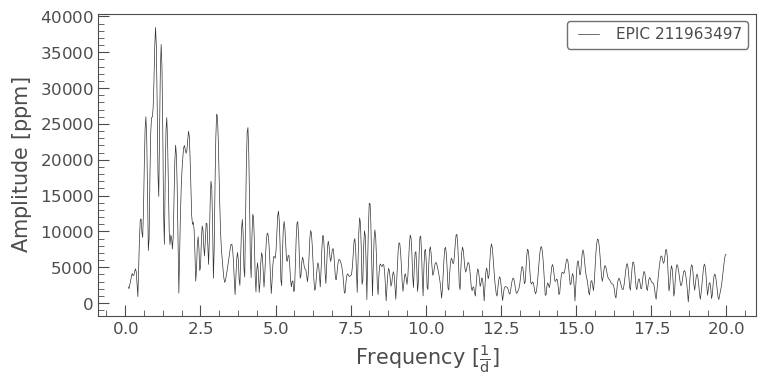

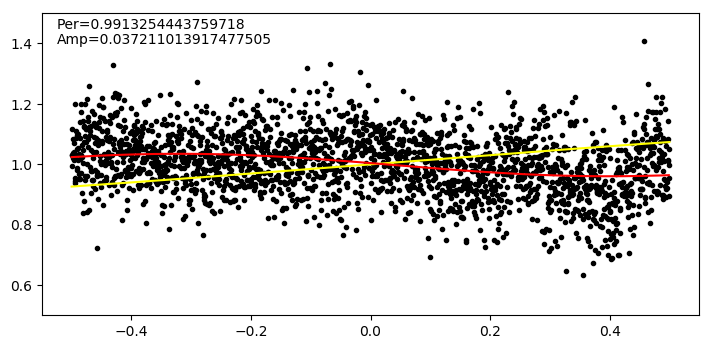

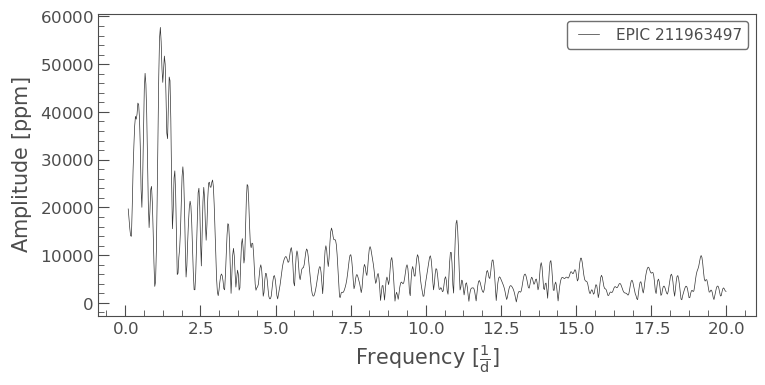

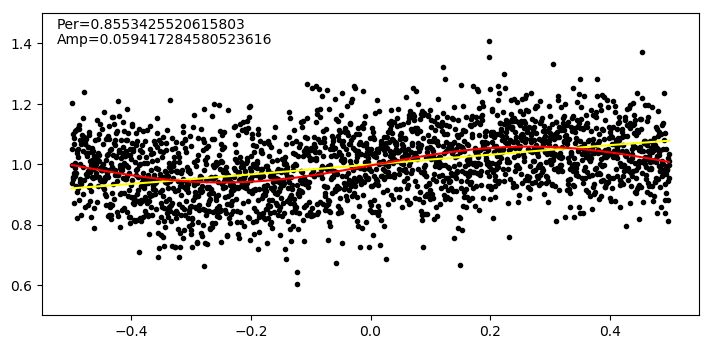

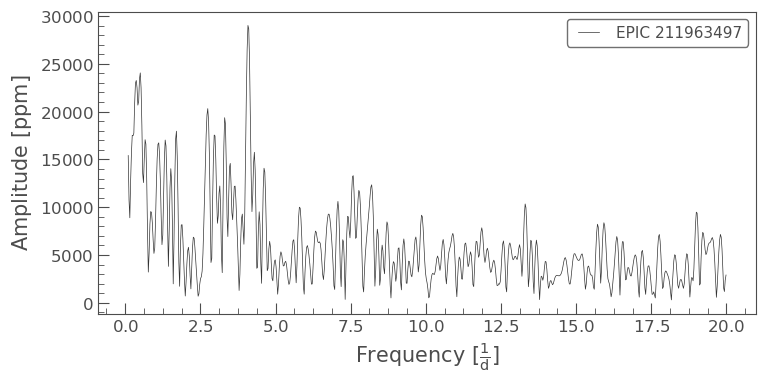

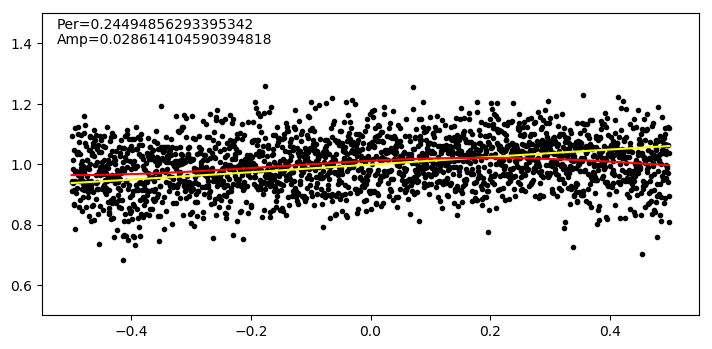

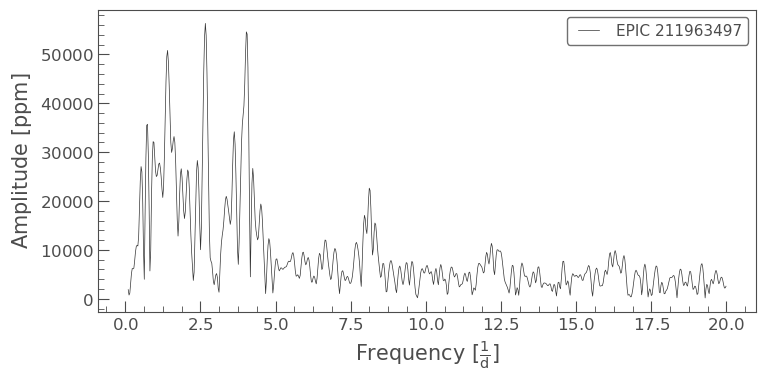

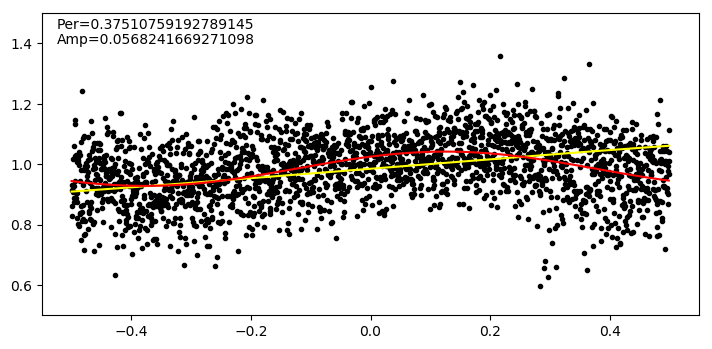

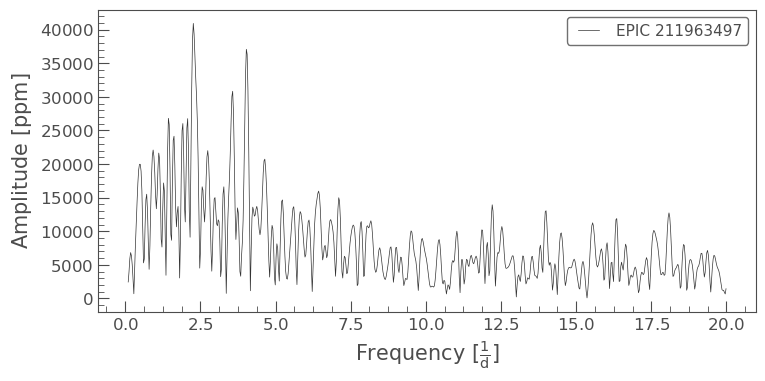

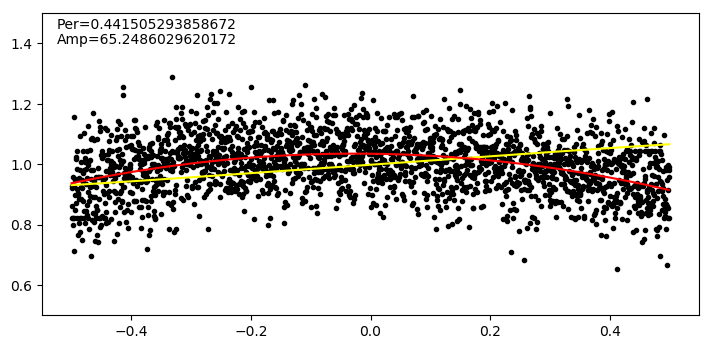

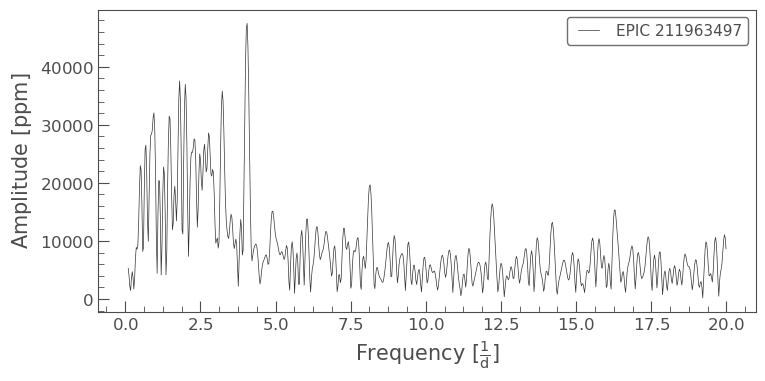

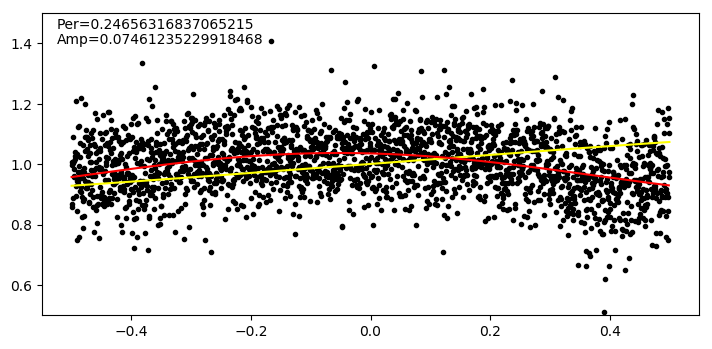

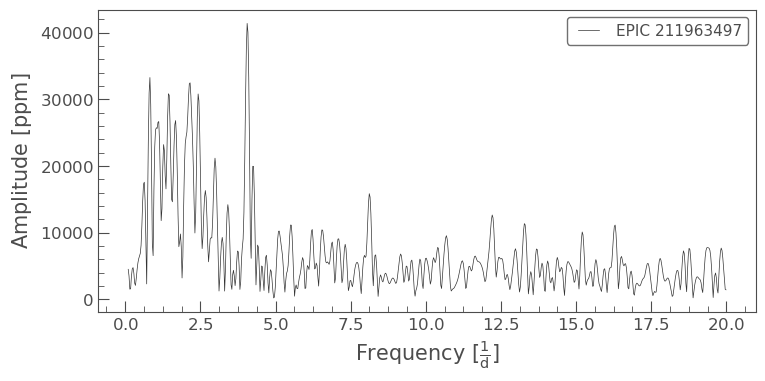

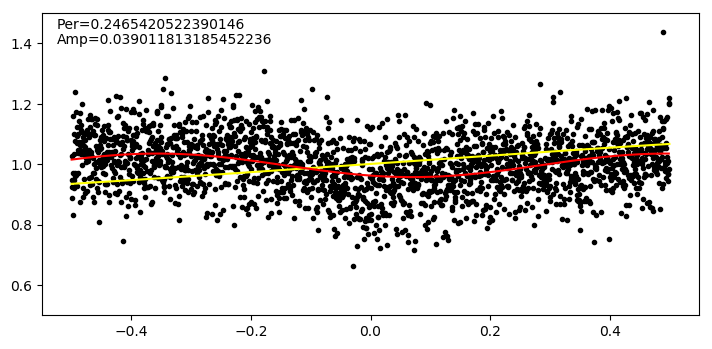

In [26]:
     x=1
     y=list_of_time_lengths[0]
     
     for i in range (1,11):
        
          print(i)
            
          periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[x:int(y)], minimum_period=0.05, maximum_period =10)
          periodogram.plot()
          periodogram.period_at_max_power

          folded_lightcurve = clc[x:int(y)].fold(periodogram.period_at_max_power.value)
          #folded_lightcurve.plot(marker='o',linestyle='none')

          bin_folded_lc = folded_lightcurve.bin(5,method='median')
          bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')
          plt.clf()

          N = len(bin_folded_lc.flux) # number of data points
          t = np.linspace(-0.5, 0.5, N)
          guess_mean = np.mean(bin_folded_lc.flux)
          guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
          guess_phase = 0
          guess_freq = 1
          guess_amp = 1
          data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
          optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
          est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
          data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
          fine_t = np.arange(-0.5,0.5,0.001)
          data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
          plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
          plt.plot(t, data_first_guess, label='first guess', color='yellow')
          plt.plot(fine_t, data_fit, label='after fitting', color='red')
          plt.text(-0.525,1.45,"Per=%s"%(periodogram.period_at_max_power.value))
          plt.text(-0.525,1.4,"Amp=%s"%(est_amp))
          plt.ylim(0.5,1.5)

          x=x+list_of_time_lengths[i-1]
          if i<10:
             y=y+list_of_time_lengths[i]
         
          print(i)
        

In [34]:
     dir_name="/Users/AllieMcCarthy/REU/K2data/"+"2M0909+19"+"_"+str(211963497)+"_"+str(5)
     print(dir_name)
     os.mkdir(dir_name)
     x=1
     y=list_of_time_lengths[0]
     for i in range (1,11):
          print(i)
          #os.chdir(dir_name)
          new_dir="/Users/AllieMcCarthy/REU/K2data/"+"2M0909+19"+"_"+str(211963497)+"_"+str(5)+"/SeparatedTime"+str(i)
          os.mkdir(new_dir)  
          os.chdir(new_dir) 
            
          periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc[x:y], minimum_period=0.05, maximum_period =10)
          periodogram.plot()
          periodogram.period_at_max_power
          plt.title(str(211963497)+"_"+str(5)+" Periodogram")
          plt.savefig(str(211963497)+"_"+str(5)+'peroiogram.png')

          folded_lightcurve = clc[x:y].fold(periodogram.period_at_max_power.value)
          folded_lightcurve.plot(marker='o',linestyle='none')
          plt.title(str(211963497)+"_"+str(5)+" Folded Light Curve")
          plt.savefig(str(211963497)+"_"+str(5)+'foldedlightcurve.png')

          bin_folded_lc = folded_lightcurve.bin(5,method='median')
          bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')
          plt.title(str(211963497)+"_"+str(5)+" Bin Folded Light Curve")
          plt.savefig(str(211963497)+"_"+str(5)+'binfoldedlc.png')
          plt.clf()

          N = len(bin_folded_lc.flux) # number of data points
          t = np.linspace(-0.5, 0.5, N)
          guess_mean = np.mean(bin_folded_lc.flux)
          guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
          guess_phase = 0
          guess_freq = 1
          guess_amp = 1
          data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
          optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
          est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
          data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
          fine_t = np.arange(-0.5,0.5,0.001)
          data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
          plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
          plt.plot(t, data_first_guess, label='first guess', color='yellow')
          plt.plot(fine_t, data_fit, label='after fitting', color='red')
          plt.text(-0.525,1.45,"Per=%s"%(periodogram.period_at_max_power.value))
          plt.text(-0.525,1.4,"Amp=%s"%(est_amp))
          plt.ylim(0.5,1.5)
          plt.title(str(211963497)+"_"+str(5)+" Sine Fitted Binned Folded Light Curve")
          plt.savefig('sinefit.png')

          x=x+list_of_time_lengths[i-1]
          if i<10:
               y=y+list_of_time_lengths[i]
          print('DONE WITH SEPARATION ANALYSIS')
          plt.close("all")


/Users/AllieMcCarthy/REU/K2data/2M0909+19_211963497_5
1
DONE WITH SEPARATION ANALYSIS
2
DONE WITH SEPARATION ANALYSIS
3
DONE WITH SEPARATION ANALYSIS
4
DONE WITH SEPARATION ANALYSIS
5
DONE WITH SEPARATION ANALYSIS
6
DONE WITH SEPARATION ANALYSIS
7
DONE WITH SEPARATION ANALYSIS
8
DONE WITH SEPARATION ANALYSIS
9
DONE WITH SEPARATION ANALYSIS
10
DONE WITH SEPARATION ANALYSIS
